# Project: 01-2024 LaborDE Analysis
## Author: Nadia Ordonez
## Step 5 LD Supervised machine learning Regression

* [1. Introduction](#1.-Introduction)
* [2. Importing data](#2.-Importing-data)  
    * [2.1 Importing libraries](#2.1-Importing-libraries) 
    * [2.2 Importing dataframe](#2.2-Importing-dataframe)
* [3. Data wrangling before regression](#3.-Data-wrangling-before-regression)
* [4. Regression analysis](#4.-Regression-analysis)
    * [4.1 Scaterplot](#4.1-Scaterplot) 
    * [4.2 Regression steps](#4.2-Regression-steps)
    * [4.3 Model performance evaluation](#4.3-Model-performance-evaluation)
* [5. Data driven insights](#5.-Data-driven-insights)

# 1. Introduction

In Step 3 Exploring relationships, a strong correlation (correlation = 1) was identified between the total number of potential company customers for LaborDE and the overall number of companies per Bundesland. This led to the formulation of the hypothesis: 

"The greater the number of total companies in a location, the greater the likelihood of potential laboratory customers for LaborDE in that region"

To test this hypothesis, I will employ a Supervised machine learning approach using a linear regression model. This method is apt for examining the relationship between the independent variable (total number of companies) and the dependent variable (total number of potential laboratory customers), quantifying the impact of changes in the former on the latter.

The hypothesis originated from Bundesland-level data, with 16 data points, corresponding to the 16 Bundesländer in Germany. Acknowledging the small dataset, I will address this limitation by leveraging a more extensive dataset, where German companies are aggregated based on postcodes. This approach aims to provide a larger and diverse set of datapoints for robust regression analyses and thorough testing of the hypothesis.

# 2. Importing data

## 2.1 Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings # This is a library that handles warnings.
warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

In [2]:
# This option ensures that the graphs you create are displayed within the notebook without the need to "call" them specifically.

%matplotlib inline

## 2.2 Importing dataframe

The hypothesis above was concluded when exploring relationships at the Bundesland level, where only 16 data points were available, which corresponded to the 16 Bundesländer in Germany. Howerver, as a rule of thumb, having at least several hundred to a few thousand datapoints is often considered a reasonable starting point for regression analysis, then I will use my dataframe were Germany companies are grouped into postcodes to run my regression analyses and test my proposed hypothesis.

In [3]:
# Define path
path = r'C:\Users\Ich\Documents\01_2024_LaborDE_analysis'

In [4]:
# Import df
df = pd.read_csv(os.path.join(path,'02_Data', 'Prepared_data', 'company_regional_step2.csv'), encoding='utf-8')

In [5]:
df.columns

Index(['plz_imputed', 'company_total', 'labor_total', 'cancer_total',
       'bundesland_en', 'plz_original', 'habitants', 'area_sqkm', 'city',
       'region', 'bundesland_de'],
      dtype='object')

In [6]:
df.head()

,plz_imputed,company_total,labor_total,cancer_total,bundesland_en,plz_original,habitants,area_sqkm,city,region,bundesland_de
0,1067,393,0,0,Saxony,1067,11957.0,6.866839,Dresden,Dresden,Sachsen
1,1069,107,0,0,Saxony,1069,25483.0,5.339213,Dresden,Dresden,Sachsen
2,1076,1,0,0,Saxony,1076,NaN,NaN,Aue-Bad Schlema,Erzgebirgskreis,Sachsen
3,1097,127,1,0,Saxony,1097,14821.0,3.298022,Dresden,Dresden,Sachsen
4,1099,202,1,0,Saxony,1099,28018.0,58.505818,Dresden,Dresden,Sachsen


In [7]:
df.shape

(9511, 11)

# 3. Data wrangling before regression

### Selecting relevant variables

In [8]:
# Subsetting dataframe
selected_variables = ['plz_imputed', 'plz_original', 'company_total', 'labor_total', 'bundesland_en', 'region']
sub_df = df[selected_variables]

In [9]:
# See results
sub_df.head()

,plz_imputed,plz_original,company_total,labor_total,bundesland_en,region
0,1067,1067,393,0,Saxony,Dresden
1,1069,1069,107,0,Saxony,Dresden
2,1076,1076,1,0,Saxony,Erzgebirgskreis
3,1097,1097,127,1,Saxony,Dresden
4,1099,1099,202,1,Saxony,Dresden


### Missing values

In [10]:
# Check for missing values
sub_df.isnull().sum()
# no missing values

plz_imputed      0
plz_original     0
company_total    0
labor_total      0
bundesland_en    0
region           0
dtype: int64

### Duplicates check

In [11]:
sub_dups = df.duplicated()

In [12]:
sub_dups.shape # No dups

(9511,)

### Extreme values checks

<Axes: xlabel='company_total', ylabel='Density'>

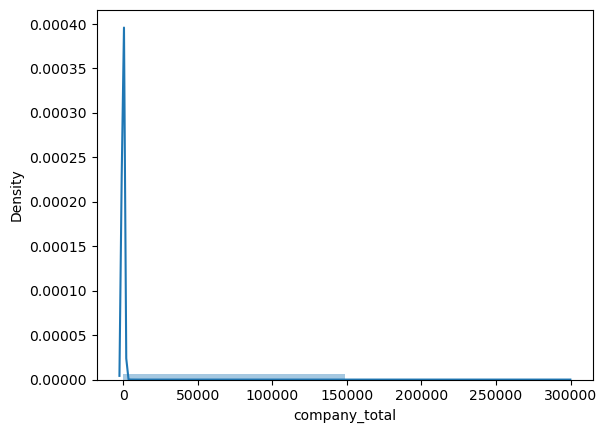

In [13]:
sns.distplot(sub_df['company_total'], bins=2) 
# some postcodes areas have a high industrial activity

In [14]:
sub_df['company_total'].mean() # Check the mean

251.65755441068237

In [15]:
sub_df['company_total'].median() # Check the median

40.0

In [16]:
sub_df['company_total'].max() # Check the max

297428

There are extreme values within the "company_total" variable. Most of values are close to 0. Some poscode areas have more than 50k listed companies. 

{'whiskers': [<matplotlib.lines.Line2D at 0x1e636fbea90>,
 'caps': [<matplotlib.lines.Line2D at 0x1e636f4f350>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e636e96290>],
 'medians': [<matplotlib.lines.Line2D at 0x1e636fcc250>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e636fcc510>],
 'means': []}

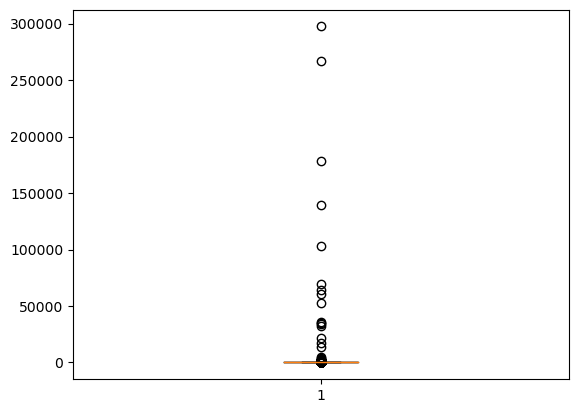

In [17]:
# Explore extrem values in detail
plt.boxplot(sub_df['company_total'])

In [18]:
# Explore extreme values
extrem = sub_df[sub_df['company_total'] > 50000]
extrem.shape

(9, 6)

In [19]:
# See results
extrem
# Although these are extrem values, they match with top industrial cities, regions and Bunsdeländer in Germany
# Thus, extrem values wont be removed

,plz_imputed,plz_original,company_total,labor_total,bundesland_en,region
196,4109,4109,64524,321,Saxony,Leipzig
720,10117,10117,60737,421,Berlin,Berlin
1704,22926,22926,52691,223,Schleswig-Holstein,Kreis Stormarn
2268,26789,26789,139657,583,Lower Saxony,Landkreis Leer
3506,40549,40549,297428,1375,North Rhine-Westphalia,Düsseldorf
4561,55129,55129,69777,284,Rhineland-Palatinate,Mainz
5024,60325,60325,103300,460,Hesse,Frankfurt am Main
5897,70173,70173,178552,903,Baden-Württemberg,Stuttgart
7093,82031,82031,266522,1141,Bavaria,Landkreis München


# 4. Regression analysis 

## 4.1 Scaterplot

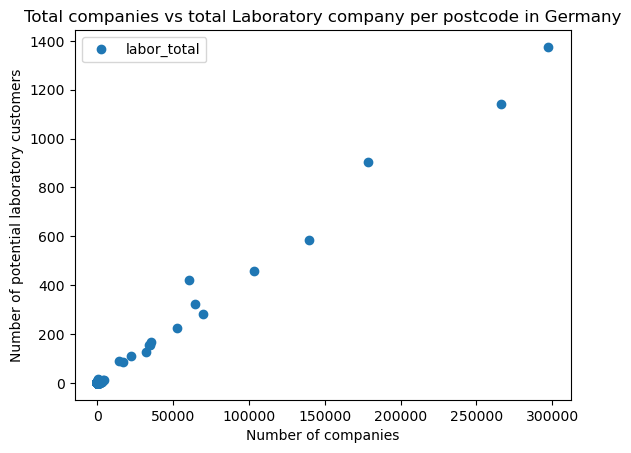

In [20]:
# Create a scatterplot using matplotlib for another look at how the chosen variables plot against each other
sub_df.plot(x = 'company_total', y='labor_total',style='o') 
# The style option creates a scatterplot; without it, we only have lines.
plt.title('Total companies vs total Laboratory company per postcode in Germany')  
plt.xlabel('Number of companies')  
plt.ylabel('Number of potential laboratory customers')  
plt.show()

## 4.2 Regression steps

### Data preparation

In [21]:
# Reshape the variables into NumPy arrays and put them into separate objects
X = sub_df['company_total'].values.reshape(-1,1)
y = sub_df['labor_total'].values.reshape(-1,1)

In [22]:
# see results
X

array([[393],
       [107],
       [  1],
       ...,
       [ 33],
       [ 10],
       [ 22]], dtype=int64)

In [23]:
# see results
y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [24]:
# Split data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# The test_size = 0.3 argument within the function is specifying that the test set should comprise 30 percent of the data 
# (thus making the training set 70 percent of the data)

### Performing a regression

In [25]:
# Create a regression object.
regression = LinearRegression()  # This is the regression object, which will be fit onto the training set

In [26]:
# Fit the regression object onto the training set
regression.fit(X_train, y_train)

LinearRegression()

In [27]:
# Predict the values of y using X
y_predicted = regression.predict(X_test)

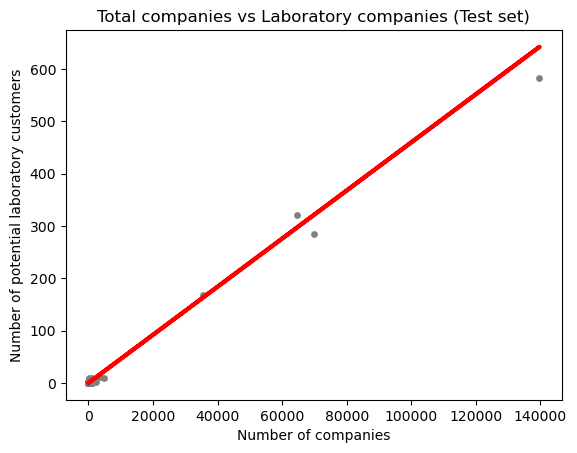

In [28]:
# Create a plot that shows the regression line from the model on the test set.
plot_test = plt
plot_test.scatter(X_test, y_test, color='gray', s = 15)
plot_test.plot(X_test, y_predicted, color='red', linewidth =3)
plot_test.title('Total companies vs Laboratory companies (Test set)')
plot_test.xlabel('Number of companies')
plot_test.ylabel('Number of potential laboratory customers')

# Save the regression line plot
plot_test.savefig(os.path.join(path, '04_Analysis', 'Visuals', 'regression_line_model_test_set.png'))

# Display the plot
plot_test.show()

The linear model, illustrated by the prominent red regression line, adeptly encompasses all the data points. This is especially evident in regions at the postal code level where numerous total companies coexist, revealing data points associated with a notably higher count of potential laboratory customers. This observation strongly corroborates my initial hypothesis.

In [29]:
# Create objects that contain the model summary statistics.
rmse = mean_squared_error(y_test, y_predicted) # This is the mean squared error
r2 = r2_score(y_test, y_predicted) # This is the R2 score 

In [30]:
# Print the model summary statistics. This is where the performance of the model is evaluated
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[0.00459817]]
Mean squared error:  2.577773410118582
R2 score:  0.9866896464042321


The positive slope coefficient (0.0046) in our model signifies a direct relationship between the number of total companies per postcode (X) and the slight increase in potential laboratory customers (y). This suggests that, as the number of total companies rises, there is a proportional rise in potential laboratory customers.

The low root mean squared error (MSE) value (2.57) indicates the accuracy of our regression line, closely aligning with the observed data points. This implies a reliable fit, with an approximate error of 3 potential laboratory companies over or under-estimated at the postcode level.

The R2 score, approaching 1, indicates that our model effectively explains the variance in the data, reinforcing its overall good fit. Collectively, these metrics affirm the strong performance of the model, suggesting that areas with a higher concentration of industrial activity correspond to an increased number of potential customers for our client, LaborDe.

## 4.3 Model performance evaluation

### Evaluation of predicted values

In [31]:
# See values that were predicted
y_predicted

array([[-0.08122706],
       [-0.07203072],
       [-0.01685269],
       ...,
       [ 0.10269972],
       [-0.08122706],
       [ 0.51193679]])

In [32]:
# Create a dataframe comparing the actual and predicted values of y
data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data.head(30)

,Actual,Predicted
0,0,-0.081227
1,0,-0.072031
2,0,-0.016853
3,0,0.934968
4,0,0.056718
5,0,0.337206
6,0,-0.081227
7,0,-0.053638
8,0,-0.044442
9,0,0.479750


Once more, the impact of 0 values in the dataframe is apparent. Nevertheless, the model continues to provide accurate estimates for potential customers of our client, LaborDe.

### Evaluation with the training set

In [33]:
# Predict
y_predicted_train = regression.predict(X_train) # This is predicting X_train!

In [34]:
rmse = mean_squared_error(y_train, y_predicted_train)
r2 = r2_score(y_train, y_predicted_train)

In [35]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[0.00459817]]
Mean squared error:  6.00999258709226
R2 score:  0.991182163935733


Together, these three metrics validate the robust performance of the model on the training data, indicating a positive correlation between areas exhibiting a higher concentration of industrial activity and an elevated number of potential customers for our client, LaborDE. These results strengthen my initial hypothesis. 

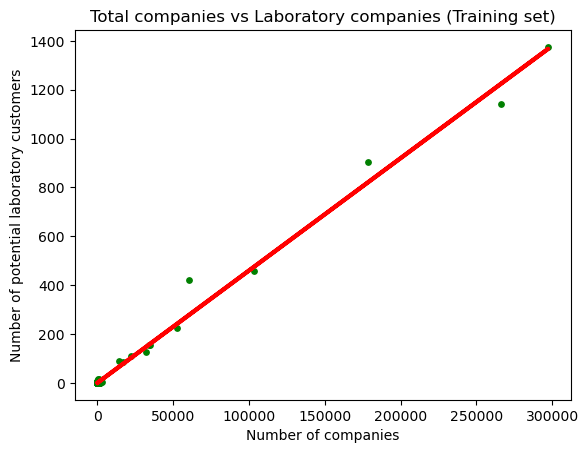

In [36]:
# Visualizing the training set results.
plot_test = plt
plot_test.scatter(X_train, y_train, color='green', s = 15)
plot_test.plot(X_train, y_predicted_train, color='red', linewidth =3)
plot_test.title('Total companies vs Laboratory companies (Training set)')
plot_test.xlabel('Number of companies')
plot_test.ylabel('Number of potential laboratory customers')
# Save the regression line plot
plot_test.savefig(os.path.join(path, '04_Analysis', 'Visuals', 'regression_line_model_training_set.png'))

# Display the plot
plot_test.show()

Likewise, this graph illustrates the proximity of data points to the regression line, providing further support for the evidence accumulated thus far in favor of my hypothesis.

# 5. Data driven insights

I've amassed substantial evidence supporting my hypothesis that a greater presence in industrial locations correlates with an increased number of potential customers for our client, LaborDe. The robust linear regression line, coupled with its strong performance metrics, reinforces this conclusion. Consequently, I recommend LaborDE strategically position its business operations in proximity to industrial areas to maximize customer acquisition.

However, it's crucial to acknowledge potential biases in the analysis, primarily stemming from filtering and imputations in the dataframe. Relying solely on company names for filtering potential customer companies may overlook some opportunities. Additionally, incomplete addresses for German companies in the original file led to postcode and region imputations based on the most common values at the regional or Bundesland level. This introduces a bias toward the most frequently listed companies.  